In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import brier_score_loss

import xgboost as xgb
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)

LOAD MODEL DATA SETS 

In [2]:
all_games_df = pd.read_csv('all_games_df.csv')

In [3]:
test_combos_df = pd.read_csv('test_combos_df_2015.csv')
test_combos_df = test_combos_df.sort_values(by=['ID']).reset_index(drop=True)

In [4]:
test_combos_df.head(3)

,Season,ID,HTeamID,RTeamID,HSeed,RSeed,is_tourney,Hwins_top25,HPointMargin,HFG,HFG3,Rwins_top25,RPointMargin,RFG,RFG3,HRankPOM,RRankPOM,home,Hconf,Hadjem,Hadjo,Hadjd,Hluck,road,Rconf,Radjem,Radjo,Radjd,Rluck,Htourny20plus,Rtourny20plus,HBig4Conf,RBig4Conf
0,2015,2015_1107_1112,1112.0,1107.0,2.0,14.0,1,3,17.823529,0.486694,0.358874,0,5.28125,0.44403,0.358773,2,132,arizona,P12,32.36,119.9,87.5,-0.033,albany,AE,3.29,107.2,103.9,0.054,1,0,0,0
1,2015,2015_1107_1116,1116.0,1107.0,5.0,14.0,1,1,7.882353,0.448082,0.347178,0,5.28125,0.44403,0.358773,29,132,arkansas,SEC,16.44,114.7,98.3,0.045,albany,AE,3.29,107.2,103.9,0.054,0,0,1,0
2,2015,2015_1107_1124,1124.0,1107.0,3.0,14.0,1,7,8.812500,0.435875,0.379881,0,5.28125,0.44403,0.358773,15,132,baylor,B12,22.14,116.6,94.5,-0.035,albany,AE,3.29,107.2,103.9,0.054,0,0,1,0


In [5]:
test_combos_df.tail()

,Season,ID,HTeamID,RTeamID,HSeed,RSeed,is_tourney,Hwins_top25,HPointMargin,HFG,HFG3,Rwins_top25,RPointMargin,RFG,RFG3,HRankPOM,RRankPOM,home,Hconf,Hadjem,Hadjo,Hadjd,Hluck,road,Rconf,Radjem,Radjo,Radjd,Rluck,Htourny20plus,Rtourny20plus,HBig4Conf,RBig4Conf
11385,2019,2019_1449_1459,1459.0,1449.0,7.0,9.0,1,0,13.666667,0.487256,0.416669,0,5.441176,0.455797,0.344894,19,51,wofford,SC,20.71,118.4,97.6,0.060,washington,P12,13.37,107.0,93.6,0.078,0,0,0,0
11386,2019,2019_1449_1463,1449.0,1463.0,9.0,14.0,1,0,5.441176,0.455797,0.344894,0,7.178571,0.496652,0.371237,51,82,washington,P12,13.37,107.0,93.6,0.078,yale,Ivy,8.59,111.7,103.1,0.057,0,0,0,0
11387,2019,2019_1458_1459,1458.0,1459.0,5.0,7.0,1,2,7.636364,0.453714,0.362185,0,13.666667,0.487256,0.416669,12,19,wisconsin,B10,23.68,110.8,87.1,-0.026,wofford,SC,20.71,118.4,97.6,0.060,1,0,1,0
11388,2019,2019_1458_1463,1458.0,1463.0,5.0,14.0,1,2,7.636364,0.453714,0.362185,0,7.178571,0.496652,0.371237,12,82,wisconsin,B10,23.68,110.8,87.1,-0.026,yale,Ivy,8.59,111.7,103.1,0.057,1,0,1,0
11389,2019,2019_1459_1463,1459.0,1463.0,7.0,14.0,1,0,13.666667,0.487256,0.416669,0,7.178571,0.496652,0.371237,19,82,wofford,SC,20.71,118.4,97.6,0.060,yale,Ivy,8.59,111.7,103.1,0.057,0,0,0,0


In [6]:
ind_var_selected = [
'is_tourney', 
'HRankPOM',
'RRankPOM',
'line',
'Hwins_top25',
'Rwins_top25',
'HPointMargin',
'RPointMargin',
'HFG',
'RFG',
'HFG3',
'RFG3',
'Hadjem',
'Hadjo',
'Hadjd',
'Hluck',
'Radjem',
'Radjo',
'Radjd',
'Rluck',
'Htourny20plus',
'Rtourny20plus',
'HBig4Conf',
'RBig4Conf', 
'HSeed',
'RSeed'
]

Note: test is 2019 predictions but our "test" holdout set is referred to as "valid"

In [7]:
#prediction set 2019
test_ids = test_combos_df['ID'].reset_index(drop=True)
X_test = test_combos_df[['is_tourney','HRankPOM','RRankPOM','Hwins_top25','Rwins_top25','HPointMargin','RPointMargin','HFG','RFG','HFG3','RFG3','Hadjem','Hadjo','Hadjd','Hluck','Radjem','Radjo','Radjd','Rluck','Htourny20plus','Rtourny20plus','HBig4Conf','RBig4Conf','HSeed','RSeed']].reset_index(drop=True)

In [8]:
#Predict the last two years as a test set (2017, 2018):
temp_df = all_games_df[all_games_df['Season']>2014]
temp_df = temp_df[temp_df['is_tourney']==1]
X_valid = temp_df[ind_var_selected].reset_index(drop=True)
y_valid = temp_df['Hwin'].reset_index(drop=True)

#Train on everything else:
temp_df1 = all_games_df[all_games_df['Season']>2014]
temp_df1 = temp_df1[temp_df1['is_tourney']==0]
temp_df2 = all_games_df[all_games_df['Season']<2015]
combined_temp_df = temp_df1.append(temp_df2)

X_train = combined_temp_df[ind_var_selected].reset_index(drop=True)
y_train = combined_temp_df['Hwin'].reset_index(drop=True)

#For final predictions:
X_train_orig = all_games_df[ind_var_selected].reset_index(drop=True)
y_train_orig = all_games_df['Hwin'].reset_index(drop=True)

In [9]:
#Create second holdout set to double-check not overfit and check model stability (season 2016)
temp_df16 = all_games_df[all_games_df['Season']==2014]
temp_df16 = temp_df16[temp_df16['is_tourney']==1]
X_valid16 = temp_df16[ind_var_selected].reset_index(drop=True)
y_valid16 = temp_df16['Hwin'].reset_index(drop=True)

temp_df1_16 = all_games_df[all_games_df['Season']==2014]
temp_df1_16 = temp_df1_16[temp_df1_16['is_tourney']==0]
temp_df2_16 = all_games_df[all_games_df['Season']!=2014]
combined_temp_df_16 = temp_df1_16.append(temp_df2_16)

X_train16 = combined_temp_df_16[ind_var_selected].reset_index(drop=True)
y_train16 = combined_temp_df_16['Hwin'].reset_index(drop=True)

In [10]:
X_test = X_test.astype("float64")

X_train_orig = X_train_orig.astype("float64")
y_train_orig = y_train_orig.astype("float64")

X_train = X_train.astype("float64")
X_valid = X_valid.astype("float64")
y_train = y_train.astype("float64")
y_valid = y_valid.astype("float64")

X_train16 = X_train16.astype("float64")
X_valid16 = X_valid16.astype("float64")
y_train16 = y_train16.astype("float64")
y_valid16 = y_valid16.astype("float64")

Scoring rules and benchmarks

In [11]:
def LogLoss(predictions, realizations):
    predictions_use = predictions.clip(0)
    realizations_use = realizations.clip(0)
    LogLoss = -np.mean( (realizations_use * np.log(predictions_use)) + 
                        (1 - realizations_use) * np.log(1 - predictions_use) )
    return LogLoss

If the model doesn't beat assuming 50% it is poor

In [12]:
bench_5050 = np.repeat(0.5, len(y_valid))

In [13]:
LogLoss(bench_5050, y_valid)

0.6931471805599454

How does this compare to Lopez and Matthews (2014 winners)?

In [14]:
Z1 = LogisticRegression(C = 1e9, random_state=23)
Z1.fit(X_train[['line']], y_train)
Z1_pred = pd.DataFrame(Z1.predict_proba(X_valid[['line']]))[1]

In [15]:
LogLoss(Z1_pred, y_valid)

0.5147809352780559

In [16]:
Z2 = LogisticRegression(C = 1e9, random_state=23)
Z2.fit(X_train[['Hadjo','Hadjd','Radjo','Radjd']], y_train)
Z2_pred = pd.DataFrame(Z2.predict_proba(X_valid[['Hadjo','Hadjd','Radjo','Radjd']]))[1]

In [17]:
LogLoss(Z2_pred, y_valid)

0.5076109247353747

In [18]:
Z1 = LogisticRegression(C = 1e9, random_state=23)
Z1.fit(X_train16[['line']], y_train16)
Z1_pred = pd.DataFrame(Z1.predict_proba(X_valid16[['line']]))[1]

In [19]:
LogLoss(Z1_pred, y_valid16)

0.5774326196491999

In [20]:
Z2 = LogisticRegression(C = 1e9, random_state=23)
Z2.fit(X_train16[['Hadjo','Hadjd','Radjo','Radjd']], y_train16)
Z2_pred = pd.DataFrame(Z2.predict_proba(X_valid16[['Hadjo','Hadjd','Radjo','Radjd']]))[1]

In [21]:
LogLoss(Z2_pred, y_valid16)

0.6035953956457044

Fit a neural network (with and without line)

Normalize data (using z-scores) before neural network

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)  # Fit only to the training data
scaled_X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
scaled_X_valid = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=X_valid.columns)

In [23]:
scaler = StandardScaler()
scaler.fit(X_train16)  # Fit only to the training data
scaled_X_train16 = pd.DataFrame(scaler.transform(X_train16), index=X_train16.index, columns=X_train16.columns)
scaled_X_valid16 = pd.DataFrame(scaler.transform(X_valid16), index=X_valid16.index, columns=X_valid16.columns)

In [24]:
#drop line from training since we won't use in predictions, need these to be same number of columns.
X_train_orig = X_train_orig.drop(['line'], axis=1)

In [25]:
scaler = StandardScaler()
scaler.fit(X_train_orig)  # Fit to all training data

scaled_X_train_orig = pd.DataFrame(scaler.transform(X_train_orig), index=X_train_orig.index, columns=X_train_orig.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

With line (note: we won't have line in the rounds after the first, but we could use this for the first round only like Lopez and Matthews did)

In [26]:
#Note: I tried logistic activation and different combinations of hidden layers/nodes
#Hyperparameters below minimized the log loss in the holdout set
#I also submited a prediction with 10 nodes in the first layer, but this is the submission that placed 4th (w/ 8 in 1st)
nn = MLPClassifier(activation='relu', hidden_layer_sizes=(8,5,3),random_state=201, max_iter=1000)
nn.fit(scaled_X_train,y_train)
nn_pred = pd.DataFrame(nn.predict_proba(scaled_X_valid))[1]

In [27]:
LogLoss(nn_pred, y_valid)

0.46603372977141155

In [28]:
#try second holdout (does worse, but still better than baseline of 54)
nn.fit(scaled_X_train16,y_train16)
nn_pred16 = pd.DataFrame(nn.predict_proba(scaled_X_valid16))[1]
LogLoss(nn_pred16, y_valid16)

0.4602824912322495

without a line

In [29]:
#Note: I tried logistic activation and different combinations of hidden layers/nodes
#Hyperparameters below minimized the log loss in the holdout set
ind_var_selected_no_line = ['is_tourney', 'Hwins_top25','Rwins_top25','HPointMargin','RPointMargin','HFG','RFG','HFG3','RFG3','HRankPOM','RRankPOM','Hadjem','Hadjo','Hadjd','Hluck','Radjem','Radjo','Radjd','Rluck','Htourny20plus','Rtourny20plus','HBig4Conf','RBig4Conf', 'HSeed','RSeed']
nn = MLPClassifier(activation='relu', hidden_layer_sizes=(7,5,3),random_state=201, max_iter=1000)
nn.fit(scaled_X_train[ind_var_selected_no_line],y_train)
nn_pred_no_line = pd.DataFrame(nn.predict_proba(scaled_X_valid[ind_var_selected_no_line]))[1]

In [30]:
LogLoss(nn_pred_no_line, y_valid)

0.4595893961317594

In [31]:
#try second holdout (does better)
nn.fit(scaled_X_train16[ind_var_selected_no_line],y_train16)
nn_pred_no_line16 = pd.DataFrame(nn.predict_proba(scaled_X_valid16[ind_var_selected_no_line]))[1]
LogLoss(nn_pred_no_line16, y_valid16)

0.4181262806776416

Try avg of line and no line:

In [32]:
avg = (nn_pred_no_line+nn_pred)/2
LogLoss(avg, y_valid)

0.45046813028574095

In [33]:
avg16 = (nn_pred_no_line16+nn_pred16)/2
LogLoss(avg16, y_valid16)

0.4341655394338781

Create test predictions

In [34]:
#different submissions: differ by first layer of nueral net
ind_var_selected_no_line = ['is_tourney', 'Hwins_top25','Rwins_top25','HPointMargin','RPointMargin','HFG','RFG','HFG3','RFG3','HRankPOM','RRankPOM','Hadjem','Hadjo','Hadjd','Hluck','Radjem','Radjo','Radjd','Rluck','Htourny20plus','Rtourny20plus','HBig4Conf','RBig4Conf', 'HSeed','RSeed']

#train model on all data (previously held out some tournaments for a test set)
nn = MLPClassifier(activation='relu', hidden_layer_sizes=(7,5,3),random_state=201, max_iter=1000)
nn.fit(scaled_X_train_orig[ind_var_selected_no_line],y_train_orig)
second_rd_submission_all = pd.DataFrame(nn.predict_proba(scaled_X_test[ind_var_selected_no_line]))

In [35]:
#Note: I'm predicting home (lower seed) win probability. Need to convert to be consistent with output file (lower team ID)
second_rd_submission = pd.merge(test_combos_df, second_rd_submission_all, left_index=True, right_index=True)

In [36]:
second_rd_submission.loc[second_rd_submission['HTeamID']<second_rd_submission['RTeamID'], 'pred'] = second_rd_submission[1]
second_rd_submission.loc[second_rd_submission['HTeamID']>second_rd_submission['RTeamID'], 'pred'] = second_rd_submission[0]

In [37]:
second_rd_submission.to_csv('Ismail_second_rd_submission_all.csv', index=False)

In [38]:
second_rd_submission = second_rd_submission[['ID','pred']]

In [39]:
second_rd_submission.head()

,ID,pred
0,2015_1107_1112,0.032467
1,2015_1107_1116,0.081709
2,2015_1107_1124,0.123742
3,2015_1107_1125,0.272260
4,2015_1107_1129,0.124018


In [40]:
second_rd_submission.tail()

,ID,pred
11385,2019_1449_1459,0.193480
11386,2019_1449_1463,0.718824
11387,2019_1458_1459,0.307783
11388,2019_1458_1463,0.894145
11389,2019_1459_1463,0.895318


In [41]:
#Export to submit to Kaggle
second_rd_submission.to_csv('Neera_submission.csv', index=False)

Other models
No model performed as well as the neural network

XGBoost

In [42]:
X_train = X_train[['is_tourney', 'Hwins_top25','Rwins_top25','HPointMargin','RPointMargin','HFG','RFG','HFG3','RFG3','HRankPOM','RRankPOM','Hadjem','Hadjo','Hadjd','Hluck','Radjem','Radjo','Radjd','Rluck','Htourny20plus','Rtourny20plus','HBig4Conf','RBig4Conf', 'HSeed','RSeed']]
X_valid= X_valid[['is_tourney', 'Hwins_top25','Rwins_top25','HPointMargin','RPointMargin','HFG','RFG','HFG3','RFG3','HRankPOM','RRankPOM','Hadjem','Hadjo','Hadjd','Hluck','Radjem','Radjo','Radjd','Rluck','Htourny20plus','Rtourny20plus','HBig4Conf','RBig4Conf', 'HSeed','RSeed']]
X_train_xgb = xgb.DMatrix(X_train, label = y_train)
X_valid_xgb = xgb.DMatrix(X_valid)

In [43]:
num_round_for_cv = 1000
param = {'max_depth':3, 'eta':0.01, 'seed':201, 'objective':'binary:logistic', 'nthread':2}


In [44]:
p = xgb.cv(param,
       X_train_xgb,
       num_round_for_cv,
       nfold = 5,
       show_stdv = False,
       verbose_eval = False,
       as_pandas = False)

In [45]:
p = pd.DataFrame(p)
use_num = p['test-error-mean'].argmin()

In [46]:
num_round = use_num
xgb_train = xgb.train(param, X_train_xgb, num_round)
xgb_valid_prob = pd.Series(xgb_train.predict(X_valid_xgb))

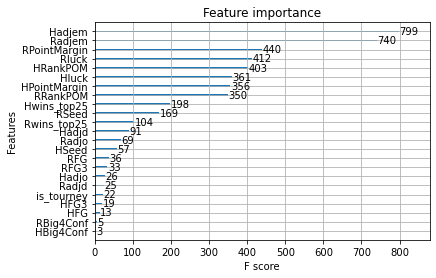

In [47]:
xgb.plot_importance(xgb_train)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [48]:
LogLoss(xgb_valid_prob, y_valid)

0.5357763210162978

In [49]:
clf = RandomForestClassifier(n_estimators=200, max_depth=3, min_samples_leaf=3)
clf.fit(X_train, y_train)
rf_prob = pd.DataFrame(clf.predict_proba(X_valid))
LogLoss(rf_prob[1], y_valid)

0.5719683760165738

In [50]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', probability= True, random_state = 0)

In [51]:
classifier.fit(scaled_X_train_orig[ind_var_selected_no_line],y_train_orig)

SVC(kernel='linear', probability=True, random_state=0)

In [64]:
second_rd_svc = pd.DataFrame(classifier.predict_proba(scaled_X_test[ind_var_selected_no_line]))

In [65]:
second_rd_submission = pd.merge(test_combos_df, second_rd_svc, left_index=True, right_index=True)

In [66]:
second_rd_submission.loc[second_rd_submission['HTeamID']<second_rd_submission['RTeamID'], 'pred'] = second_rd_submission[1]
second_rd_submission.loc[second_rd_submission['HTeamID']>second_rd_submission['RTeamID'], 'pred'] = second_rd_submission[0]

In [67]:
second_rd_submission = second_rd_submission[['ID','pred']]

In [68]:
second_rd_submission.tail()

,ID,pred
11385,2019_1449_1459,0.267258
11386,2019_1449_1463,0.768173
11387,2019_1458_1459,0.509793
11388,2019_1458_1463,0.835248
11389,2019_1459_1463,0.857561


In [69]:
second_rd_submission.to_csv('SVC_Ismail_submission.csv', index=False)

In [52]:
avg = (rf_prob[1]+xgb_valid_prob+nn_pred)/3

In [53]:
LogLoss(avg, y_valid)

0.5107978217643909

trying to see how VotingClassifier will perform 

In [70]:
Z1 = LogisticRegression(C = 1e9, random_state=23)
clf2 = RandomForestClassifier(n_estimators=200, max_depth =3, min_samples_leaf=3)
nn = MLPClassifier(activation='relu', hidden_layer_sizes=(7,5,3),random_state=201, max_iter=1000)
clf3 = SVC(kernel = 'linear', probability= True, random_state = 0)

In [71]:
eclf1 = VotingClassifier(estimators=[
         ('linear', clf3), ('relu', nn)], voting='soft')
eclf1 = eclf1.fit(scaled_X_train_orig[ind_var_selected_no_line],y_train_orig)

In [72]:
second_rd_submission_all = pd.DataFrame(eclf1.predict_proba(scaled_X_test[ind_var_selected_no_line]))

In [73]:
second_rd_submission = pd.merge(test_combos_df, second_rd_submission_all, left_index=True, right_index=True)

In [74]:
second_rd_submission.loc[second_rd_submission['HTeamID']<second_rd_submission['RTeamID'], 'pred'] = second_rd_submission[1]
second_rd_submission.loc[second_rd_submission['HTeamID']>second_rd_submission['RTeamID'], 'pred'] = second_rd_submission[0]

In [75]:
second_rd_submission.to_csv('voting_soft_second_rd_submission_all.csv', index=False)

In [76]:
second_rd_submission = second_rd_submission[['ID','pred']]

In [77]:
second_rd_submission.head()

,ID,pred
0,2015_1107_1112,0.040111
1,2015_1107_1116,0.104300
2,2015_1107_1124,0.107679
3,2015_1107_1125,0.456252
4,2015_1107_1129,0.149491


In [78]:
second_rd_submission.tail()

,ID,pred
11385,2019_1449_1459,0.230369
11386,2019_1449_1463,0.743499
11387,2019_1458_1459,0.408788
11388,2019_1458_1463,0.864696
11389,2019_1459_1463,0.876439


In [79]:
second_rd_submission.to_csv('SVC_now_vote_Ismail_submission.csv', index=False)